In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)

In [3]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
df = pd.read_csv('../06ANN_module/fashion-mnist_test.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df.shape


(10000, 785)

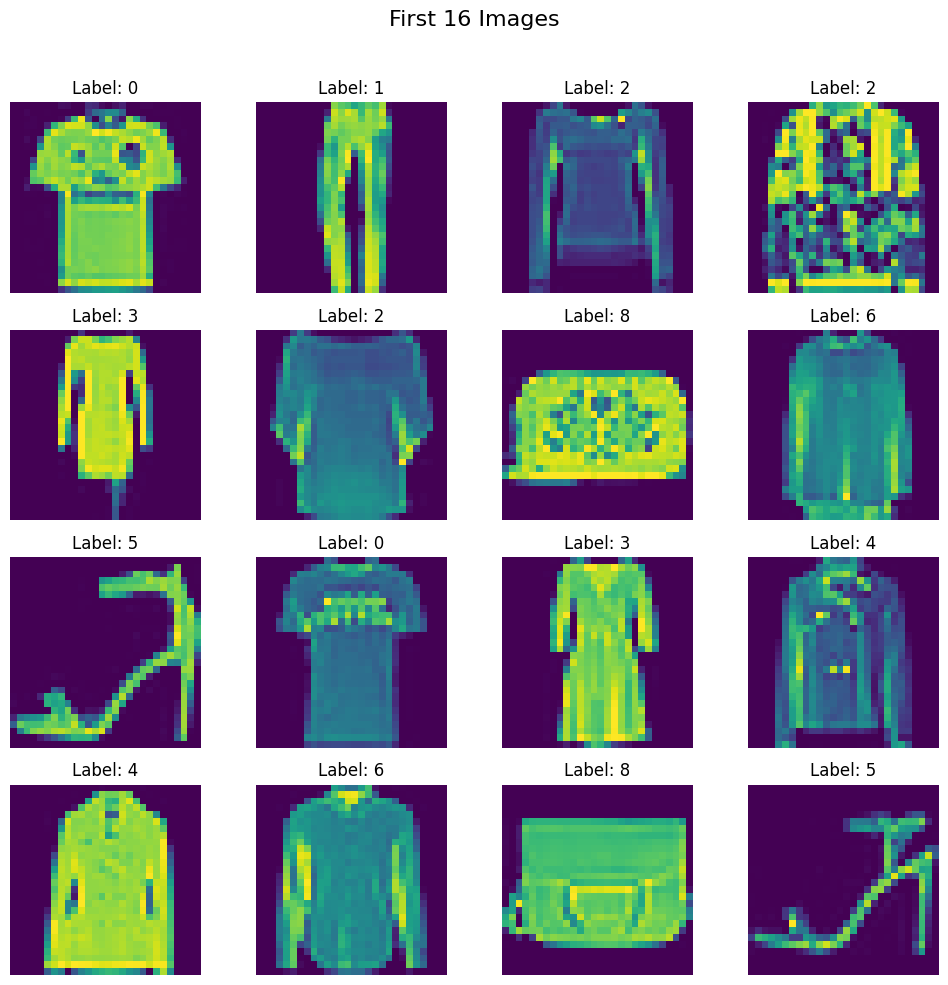

In [6]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


In [7]:
# train test split

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# transformations
from torchvision.transforms import transforms

custom_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
from PIL import Image
import numpy as np

class CustomDataset(Dataset):

  def __init__(self, features, labels, transform):
    self.features = features
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):

    # resize to (28, 28)
    image = self.features[index].reshape(28,28)

    # change datatype to np.uint8
    image = image.astype(np.uint8)

    # change black&white to color -> (H,W,C) -> (C,H,W)
    image = np.stack([image]*3, axis=-1)

    # convert array to PIL image
    image = Image.fromarray(image)

    # apply transforms
    image = self.transform(image)

    # return
    return image, torch.tensor(self.labels[index], dtype=torch.long)

In [11]:
train_dataset = CustomDataset(X_train, y_train, transform=custom_transform)

In [12]:
test_dataset = CustomDataset(X_test, y_test, transform=custom_transform)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [14]:
# fetch the pretrained model

import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)

/home/sharyar/Desktop/Aritificial_Intelligence/myenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sharyar/Desktop/Aritificial_Intelligence/myenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
# this is how we freezing cnn part 
for param in vgg16.features.parameters():
  param.requires_grad=False

In [17]:
# here we connect our own model classifier for training
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 10)
)

In [18]:
vgg16 = vgg16.to(device)


In [22]:
# import torch
# print(torch.cuda.is_available())
# print(torch.cuda.device_count())
# print(torch.cuda.current_device())
# print(torch.cuda.get_device_name(torch.cuda.current_device()))


In [36]:
learning_rate = 0.001
epochs = 100

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=learning_rate)

In [42]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = vgg16(batch_features)

    # print(outputs.shape)
    # print(batch_labels.shape)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

    break

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


Epoch: 1 , Loss: 0.0010527282953262328
Epoch: 2 , Loss: 0.0007174482941627502
Epoch: 3 , Loss: 0.0011498886346817017
Epoch: 4 , Loss: 0.0025521554946899413
Epoch: 5 , Loss: 0.0012941305637359619
Epoch: 6 , Loss: 0.0011304821968078614
Epoch: 7 , Loss: 0.0006815456748008728
Epoch: 8 , Loss: 0.001852877140045166
Epoch: 9 , Loss: 0.0015780876874923707
Epoch: 10 , Loss: 0.0005267099738121033
Epoch: 11 , Loss: 0.0009599994421005249
Epoch: 12 , Loss: 0.0004466477334499359
Epoch: 13 , Loss: 0.001775126576423645
Epoch: 14 , Loss: 0.001007793426513672
Epoch: 15 , Loss: 0.0014224257469177247
Epoch: 16 , Loss: 0.0016185609102249145
Epoch: 17 , Loss: 0.0011035773754119872
Epoch: 18 , Loss: 0.0005018353462219238
Epoch: 19 , Loss: 0.00033991903066635134
Epoch: 20 , Loss: 0.00047901844978332517
Epoch: 21 , Loss: 0.0008501839637756347
Epoch: 22 , Loss: 0.000765917420387268
Epoch: 23 , Loss: 0.001691495418548584
Epoch: 24 , Loss: 0.0007265105843544007
Epoch: 25 , Loss: 0.0014102332592010498
Epoch: 26 , 

In [39]:
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = vgg16(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

In [41]:
# evaluation on training data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = vgg16(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.907125
